Загружаем используемые библиотеки.

In [1]:
import os
import numpy as np 
import pandas as pd 
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import copy
from PIL import Image

%matplotlib inline

Загружаем данные.

In [3]:
female_dir = '../input/gender-classification/internship_data/female'
male_dir = '../input/gender-classification/internship_data/male'
female_files = os.listdir(female_dir)
male_files = os.listdir(male_dir)

Я запускала код в notebook на kaggle. И получалось, что в обоих папках(female и male) образовывалась папка '.ipynb_checkpoint', из-за которой не происходило обучение. Поэтому нужен был следующий фильтр.

In [4]:
female_files = [x for x in female_files if '.jpg' in x]
male_files = [x for x in male_files if '.jpg' in x]


Далее я делила данные на тестовый набор и тренировочный.

In [5]:
from sklearn.model_selection import train_test_split
train_female, test_female = train_test_split(female_files, test_size = 0.2)
train_male, test_male = train_test_split(male_files, test_size = 0.2)

Далее создала класс WholeDataset, при помощи которого размечала данные и сконкатенировала датасеты с женщинами и мужчинами в один общий. Изображения имеют разные размерности, поэтому все они были изменены под размер 256x256, и затем растянуты равномерно при помощи CenterCrop(). Ну и применяем RandomHorizontalFlip() как технику аугментации данных.

In [49]:
class WholeDataset(Dataset):
    def __init__(self, file_list, dir, mode='train', transform = None, female =None):
        self.file_list = file_list
        self.dir = dir
        self.mode= mode
        self.transform = transform
        if self.mode == 'train':
            if female:
                self.label = 1
            else:
                self.label = 0
            
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.dir, self.file_list[idx]))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            img = img.numpy()
            return img.astype('float32'), self.label
        else:
            img = img.numpy()
            return img.astype('float32') , self.file_list[idx]
        
data_transform = transforms.Compose( [
    transforms.Resize(256),
    transforms.CenterCrop(227),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
]
)

females = WholeDataset(train_female, female_dir, transform = data_transform, female =True)
males = WholeDataset(train_male, male_dir, transform = data_transform, female= False)

data_train = ConcatDataset([females, males])


Выделила также тестовую выборку.

In [50]:
test_females = WholeDataset(test_female, female_dir, mode = 'test',transform = data_transform, female =True)
test_males = WholeDataset(test_male, male_dir, mode = 'test', transform = data_transform, female =False)
data_test = ConcatDataset([test_females, test_males])

Далее из тренировочного датасета выбрала 30% на валидационную выборку. И загрузила обе выборки через DataLoader.

In [51]:
batch_size = 64

data_size = len(data_train)
validation_split = .3
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

Визуализация семпла из тренировочной выборки.

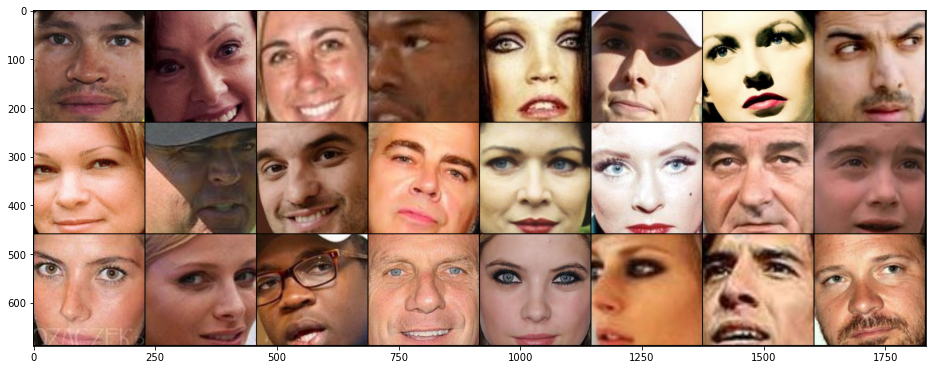

In [52]:
samples, labels = iter(train_loader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

Описание модели.

In [53]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [54]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 96, 7, stride = 4, padding = 1)
        self.pool1 = nn.MaxPool2d(3, stride = 2, padding = 1)
        self.norm1 = nn.LocalResponseNorm(size = 5, alpha = 0.0001, beta = 0.75)
        
        self.conv2 = nn.Conv2d(96, 256, 5, stride = 1, padding = 2)
        self.pool2 = nn.MaxPool2d(3, stride = 2, padding = 1)
        self.norm2 = nn.LocalResponseNorm(size = 5, alpha = 0.0001, beta = 0.75)
        
        self.conv3 = nn.Conv2d(256, 384, 3, stride = 1, padding = 1)
        self.pool3 = nn.MaxPool2d(3, stride = 2, padding = 1)
        self.norm3 = nn.LocalResponseNorm(size = 5, alpha = 0.0001, beta = 0.75)
        
        self.fc1 = nn.Linear(18816, 512)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(512, 512)
        self.dropout2 = nn.Dropout(0.5)
  
        self.fc3 = nn.Linear(512, 10)
    
        self.apply(weights_init)

    
    def forward(self, x):
        x = nn.functional.leaky_relu(self.conv1(x))
        x = self.pool1(x)
        x = self.norm1(x)

        x = nn.functional.leaky_relu(self.conv2(x))
        x = self.pool2(x)
        x = self.norm2(x)
      
        x = nn.functional.leaky_relu(self.conv3(x))
        x = self.pool3(x)
        x = self.norm3(x)
      
        x = x.view(-1, 18816)
        
        x = self.fc1(x)
        x = nn.functional.leaky_relu(x)
        x = self.dropout1(x)
      
        x = self.fc2(x)
        x = nn.functional.leaky_relu(x)
        x = self.dropout2(x)
      
        x = nn.functional.log_softmax(self.fc3(x), dim=1)
  
        return x

In [55]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0, std=1e-2)

Гиперпараметры были определены опытным путем и вычислительными возможностями.

In [56]:
batch_size = 64
lr = 0.0001
num_epochss = 5

In [57]:
import torch.optim as optim

nn_model = Net()
nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.Adam(nn_model.parameters(), lr)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10000])


Сам процесс тренировки. В результате имеем по эпохам изменение ошибки и accuracy тренировочной и валидационной выборки.

In [58]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None,):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() 
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value
        
        if scheduler:
            scheduler.step() 
    
        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval()
    correct_samples = 0
    total_samples = 0
    for (x, y) in loader:
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        
        prediction = model(x_gpu)    

        indices = torch.argmax(prediction, 1)
        correct_samples += torch.sum(indices == y_gpu)
        total_samples += y_gpu.shape[0]
    
    val_accuracy = float(correct_samples) / total_samples
    return val_accuracy




loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer,num_epochss, scheduler)

Average loss: 0.598209, Train accuracy: 0.652714, Val accuracy: 0.866333
Average loss: 0.231795, Train accuracy: 0.907982, Val accuracy: 0.929833
Average loss: 0.168365, Train accuracy: 0.934250, Val accuracy: 0.942542
Average loss: 0.145563, Train accuracy: 0.942857, Val accuracy: 0.951000
Average loss: 0.129361, Train accuracy: 0.949482, Val accuracy: 0.948458


Сохраняем полученную модель.

In [60]:
PATH_TO_MODELS='./'
filename = 'my_model'

In [61]:
torch.save(nn_model.state_dict(), f'{PATH_TO_MODELS}/{filename}.pt')


Далее идет функция передачи изображений и запись в json-файл результата.

In [62]:
mapping = {
    0: 'male',
    1: 'female'
}

def test_on_a_class(image_tensor):
    with torch.no_grad():
        net = Net().to(device)
        net.load_state_dict(torch.load(f'{PATH_TO_MODELS}/{filename}.pt'))
        net.eval()       
        output = net(image_tensor)
        output = torch.max(output, 1)[1].to(device)
        result = f'{mapping[output.item()]}'
        
    
    return result   

In [63]:
def test(path):
    image = Image.open(path)
    plt.imshow(image)
    trans = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(227),
                transforms.ToTensor()
            ]
    )
    image = trans(image)
    image.unsqueeze_(0)
    image = image.to(device)
    return test_on_a_class(image)

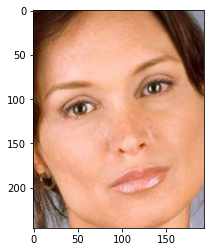

In [64]:
import json
json_obj = {}

for file in test_female:
    json_obj.update({file: test(f'{female_dir}/{file}')})
    break
    
with open('process_results.json','w') as jsonFile:
    json.dump(json_obj, jsonFile)